## Introduction

This document presents a comprehensive exploratory data analysis and predictive modeling study focused on healthcare insurance premium prediction for a young population aged 18–25. The primary objective is to evaluate how demographic, socioeconomic, lifestyle, medical, and genetical risk factors influence annual premium amounts within this age group.

The analysis begins with rigorous data cleaning and preprocessing, including handling missing values, correcting inconsistent categorical labels, treating outliers in income, and resolving data quality issues such as negative dependent counts. Extensive exploratory data analysis (EDA) is conducted to understand variable distributions, category proportions, and relationships between features and the target variable.

Feature engineering plays a central role in this study, particularly through the construction of medical and genetical risk scores, normalization of numerical variables, encoding of categorical features, and multicollinearity assessment using VIF. Multiple regression-based and machine learning models—Linear Regression, Ridge Regression, and XGBoost—are trained and evaluated to assess predictive performance for premium estimation in the young demographic.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
# Loading the data
df= pd.read_excel('premiums_young_with_gr.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [3]:
# Number of rows and columns in the data
df.shape

(20096, 14)

In [4]:
# converting  all columns into consistent naming
df.columns = df.columns.str.replace(' ', '_' ).str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [5]:
# Finding null values
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [6]:
# Dropping the null values
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [7]:
# Finding duplicate values
df.duplicated().sum()

0

In [8]:
# Getting more information about the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [9]:
# Getting info about number of dependants which are negative values
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [10]:
# Number of rows where number of dependants is less than zero
df[df.number_of_dependants<0].shape

(22, 14)

In [11]:
# Changing negative values of dependants positive
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [12]:
# Getting more information about number of dependants
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

After removing the negative values, it is clear that number of dependants varies from 0 to 3

In [13]:
# finding the numerical columns
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

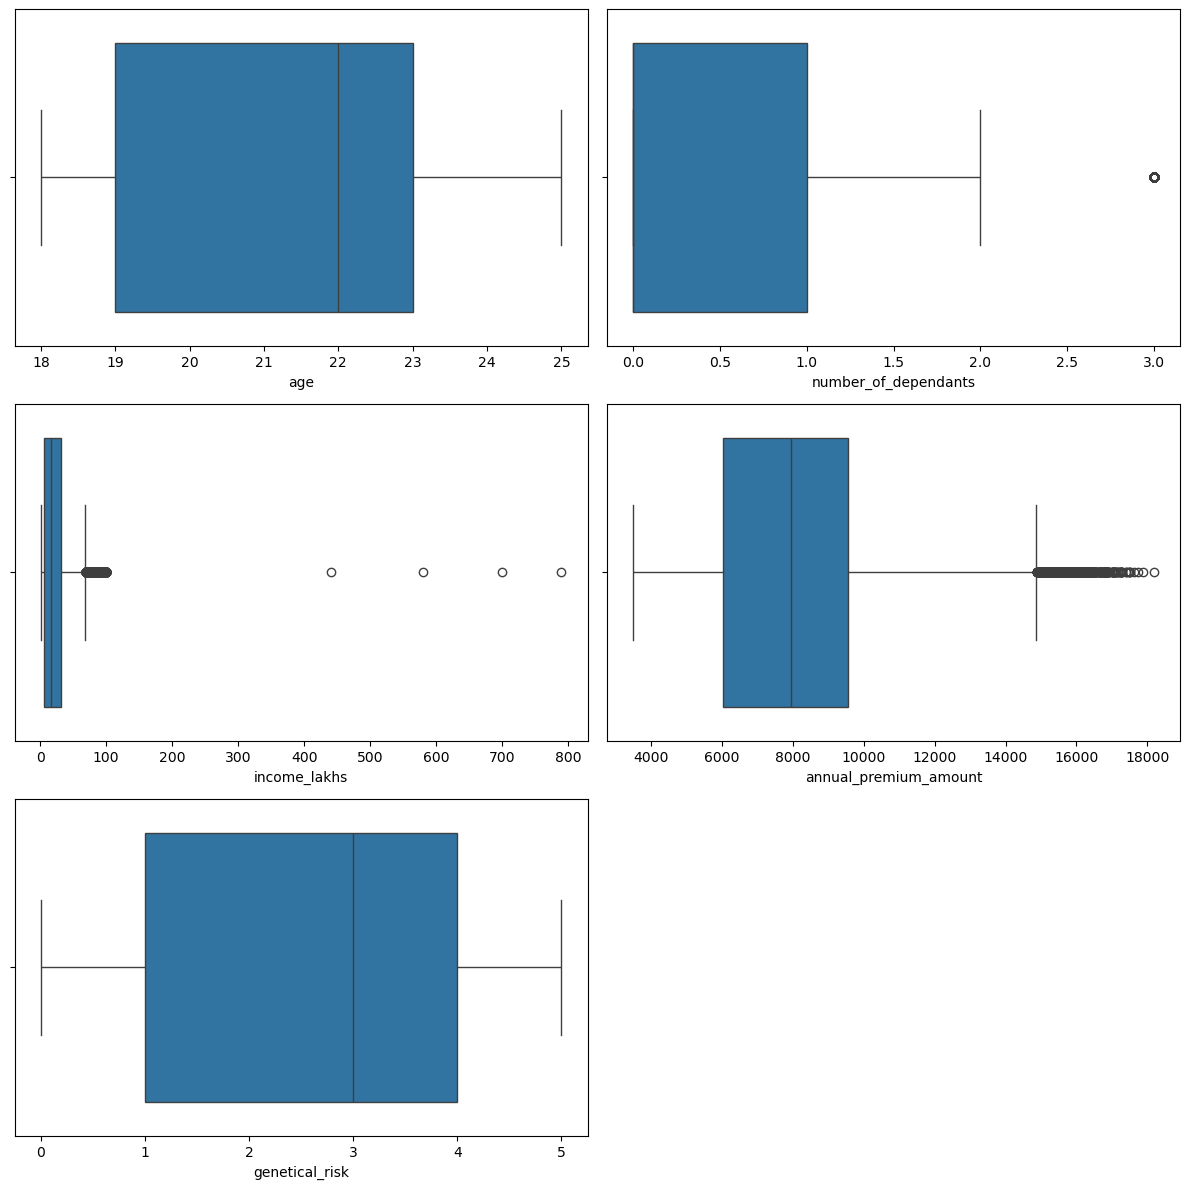

In [14]:
# plotting the numeric columns
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_columns[:5]):
    sns.boxplot(x=df[col], ax=axes[i])

# Hide the 6th subplot if only 5 numeric columns
axes[5].set_visible(False)

plt.tight_layout()
plt.show()


Age is tightly grouped (19–24) with no major outliers.

Dependents mostly 0–1, with one outlier at 3.

Income is heavily skewed with several extreme high-income outliers.

Annual premium ranges around 5k–12k but shows many high-end outliers.

Genetical risk is evenly distributed from 0–5 with no notable outliers.

In [15]:
# Finding the rows where age is greater than 100
df[df.age>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


In [16]:
# finding uniques values of age over 100
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [17]:
# Generating the dataset having age less or equal to 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

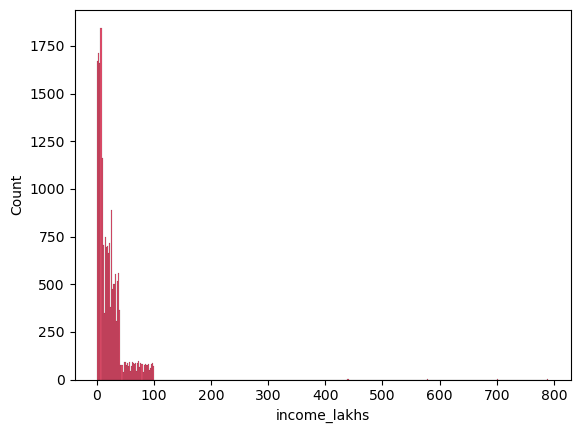

In [18]:
# Plotting the income_lakhs
sns.histplot(df1.income_lakhs,  color = 'crimson')

The histogram shows that most incomes cluster below ~50 lakhs, with counts dropping sharply as income increases. A few extreme outliers extend up to ~800 lakhs, creating a long right-skewed tail

In [19]:
# Getting the quartile values for income
df1.income_lakhs.quantile([0.25, 0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [20]:
# getting upper bound and lower bound of income values
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 +1.5 * IQR
    return lower_bound, upper_bound

In [21]:
# Setting the income threshold
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [22]:
# Finding the rows where income is greater than threshold value
df1[df1.income_lakhs > quantile_threshold].shape

(4, 14)

In [23]:
# getting the dataset where income is less than the income threshold value
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.shape

(20086, 14)

In [24]:
# Getting information about the new dataset
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


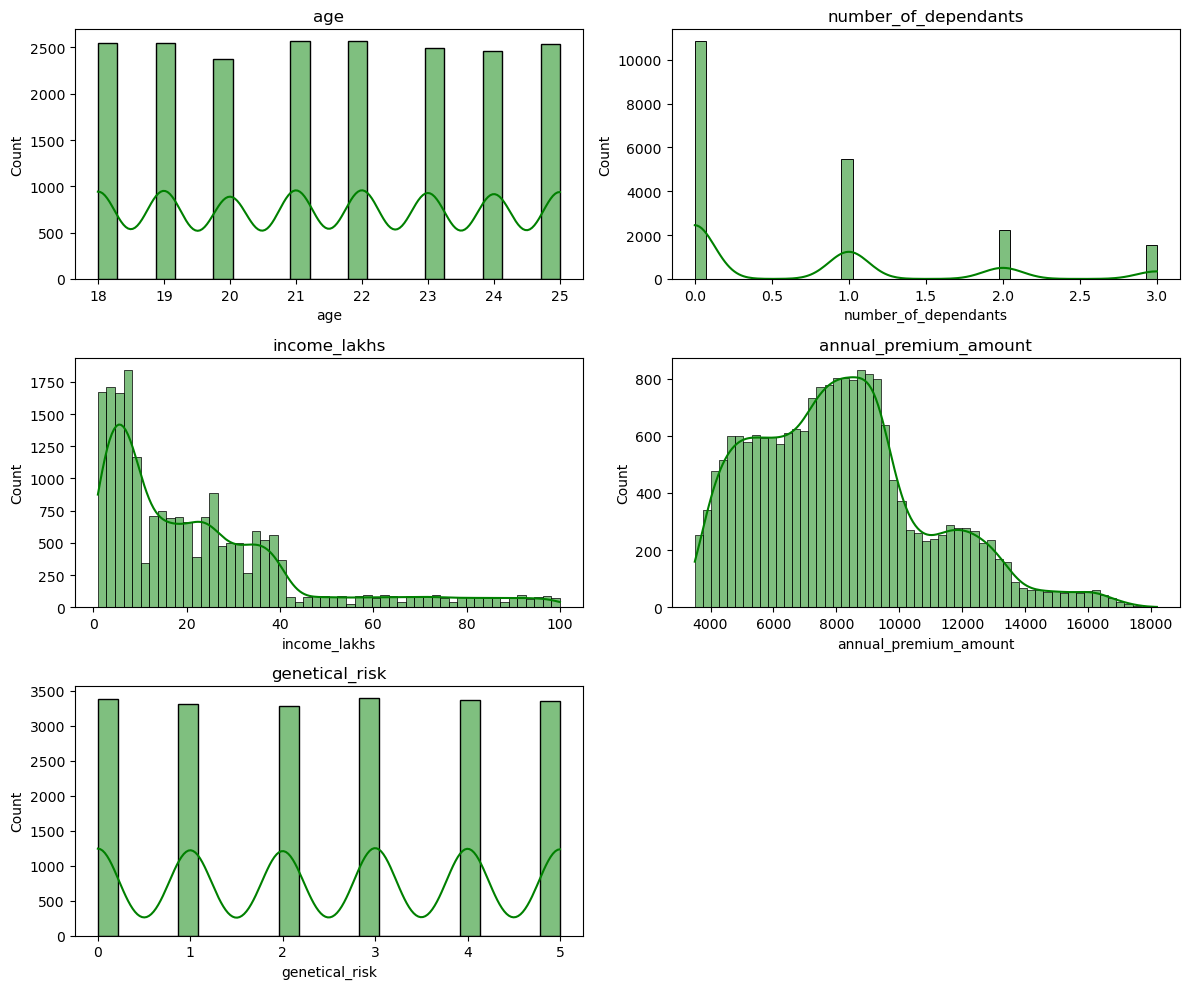

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i], color='green')
    axes[i].set_title(col)

# Turn off the extra panel (6th)
axes[-1].axis("off")

plt.tight_layout()
plt.show()


The plots show that age and genetical risk are evenly distributed across their discrete categories.
Number of dependents is mostly 0, with fewer people having 1–3 dependents.
Income is right-skewed, with most people earning under 20 lakhs.
Annual premium amounts cluster mainly between 7,000–10,000, with a smaller higher-premium group.
Overall, the data appears partly synthetic due to the uniform patterns in some variables.

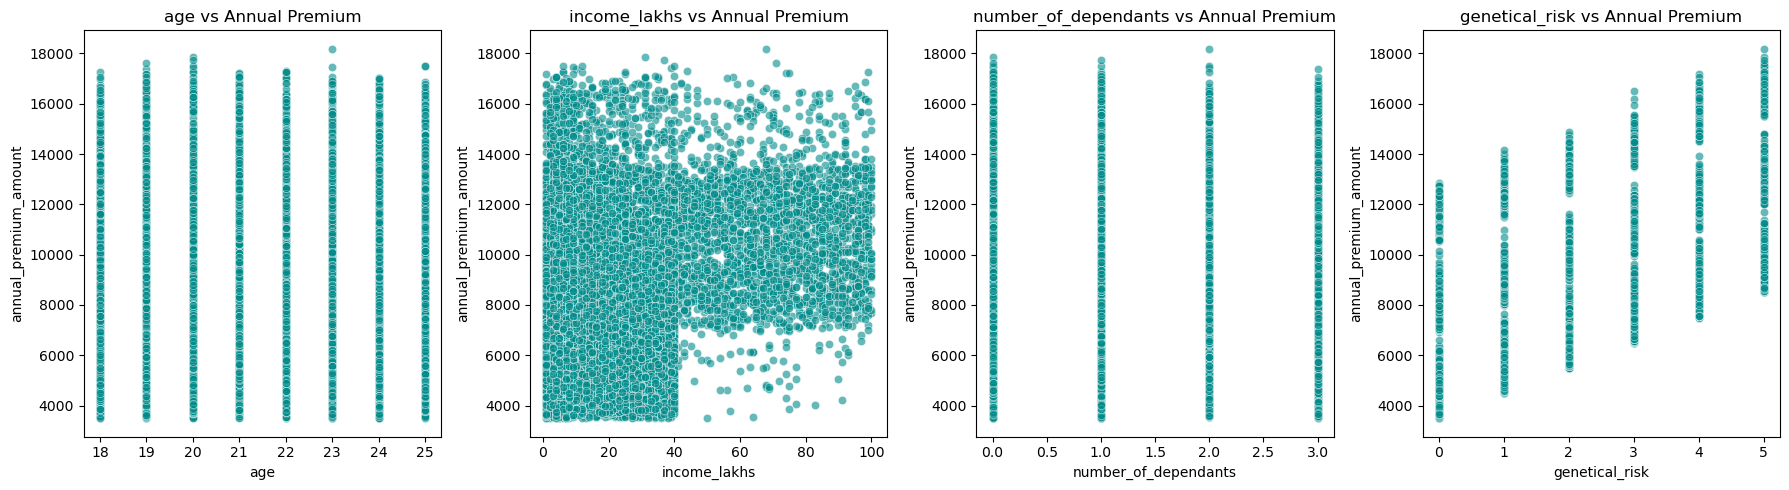

In [26]:
# Getting the scatter plot for age, income_lakhs, number of dependants, genetical_risk vs annual premium amount

import matplotlib.pyplot as plt
import seaborn as sns

features = ['age', 'income_lakhs', 'number_of_dependants','genetical_risk']

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for ax, col in zip(axes, features):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', alpha=0.6, ax=ax, color='darkcyan')
    ax.set_title(f'{col} vs Annual Premium')

plt.tight_layout()
plt.show()


The plots show that age, income, and number of dependents have no clear relationship with annual premium.
Premium values are widely scattered for these variables, indicating weak predictive power.
In contrast, genetical risk shows a strong upward trend, with higher risk leading to higher premiums.
Overall, genetical risk is the only variable strongly influencing the annual premium.


In [27]:
# getting the subcategories in the different category columns
categorical_cols = df2.select_dtypes(['object']).columns
for col in categorical_cols:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [28]:
# Changing the different non-smoking categories to No Smoking 
df2['smoking_status'] = df2['smoking_status'].replace(
    {
        'Smoking=0': 'No Smoking',
        'Does Not Smoke': 'No Smoking',
        'Not Smoking': 'No Smoking'
    }
)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [29]:
# getting the gender count
df2['gender'].value_counts()

gender
Male      11055
Female     9031
Name: count, dtype: int64

In [30]:
# percentage count of the gender values
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [31]:
pct_count.values

array([0.55038335, 0.44961665])

<Axes: xlabel='gender'>

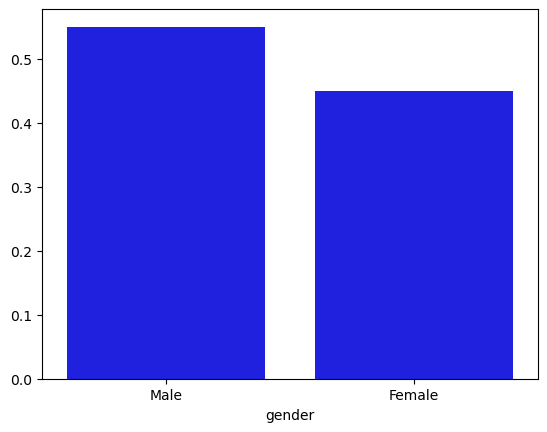

In [32]:
# Bar plot of the gender percentage count
sns.barplot(x=pct_count.index, y=pct_count.values, color = 'blue')

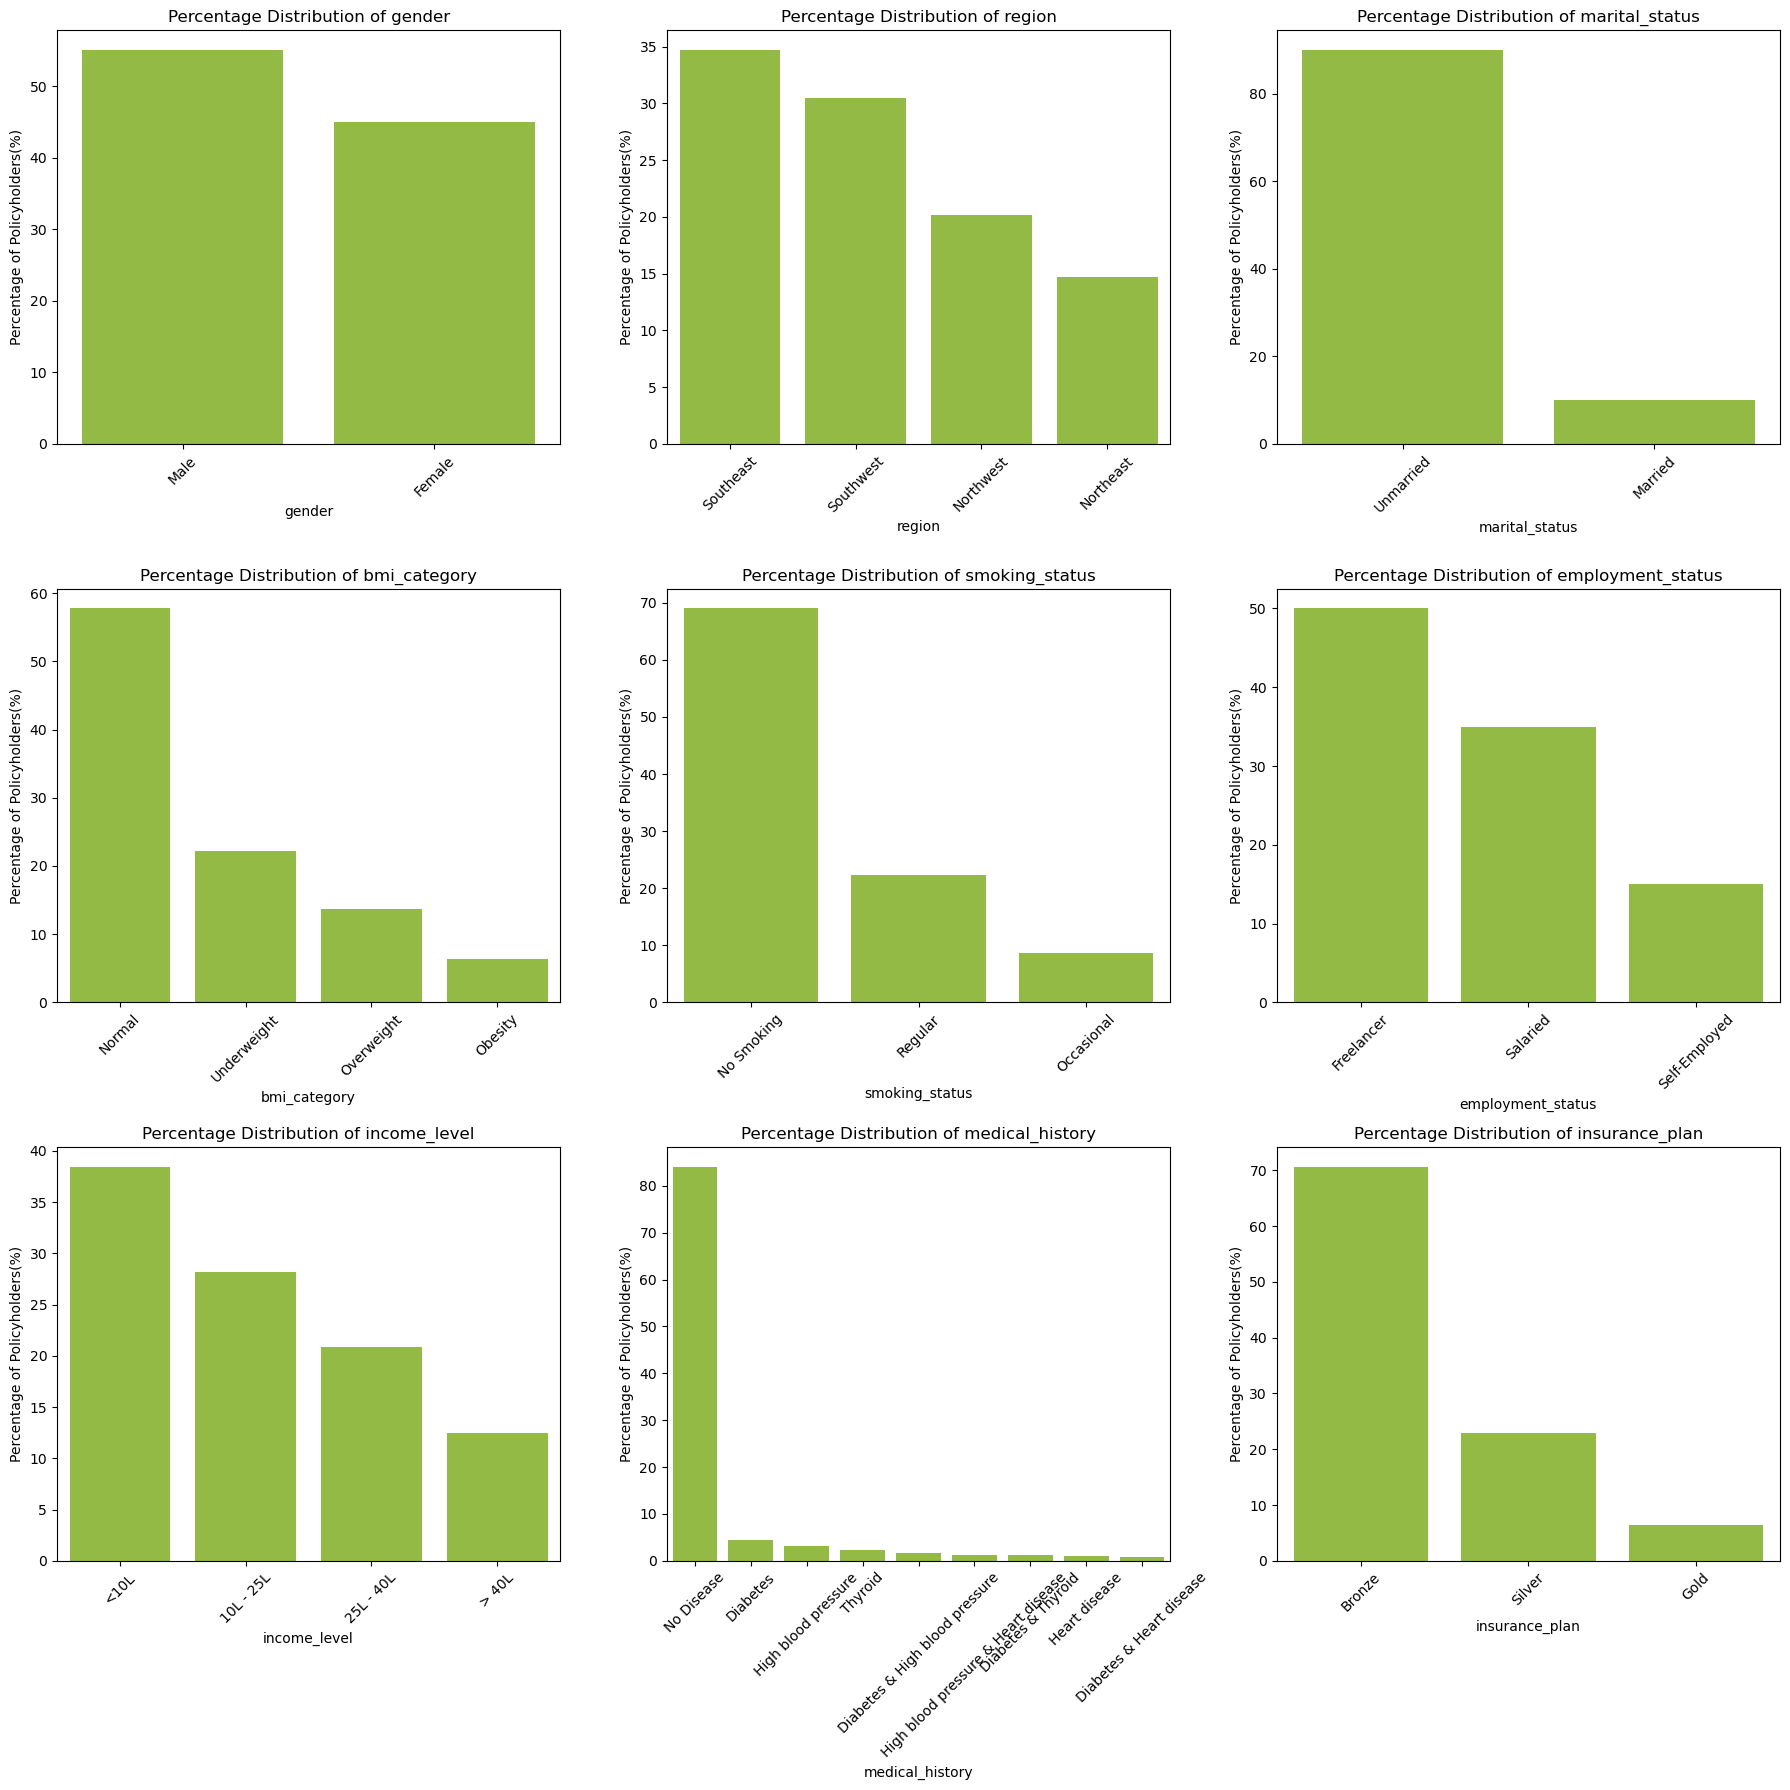

In [33]:
# Plotting pencentage of policy holders w.r.t different categories
fig, axes = plt.subplots(3, 3, figsize=(18,18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True)*100  # normalize =True gives the relation

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, color='yellowgreen')
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders(%)')
    ax.set_label(column)     # Set xlabel to the column name for clarity

    # Rotate labels for better readability
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()   # Adjusts plot parameters for better fit in the figure window
plt.show()

Gender: The dataset has slightly more males than females.

Region: Most participants come from the Southeast, followed by Southwest and Northwest.

Marital Status: A large majority are unmarried, with very few married individuals.

BMI Category: Most fall in the normal BMI range; obesity is least common.

Smoking Status: Non-smokers dominate, while occasional smokers are a small minority.

Employment Status: Full-time employment is most common, with fewer unemployed individuals.

Income Level: The largest group earns under $25k, and income decreases as the brackets rise.

Medical History: Most report no medical issues; all listed conditions have very small proportions.

Insurance Plan: Basic plans are most common, followed by Silver and then Gold.

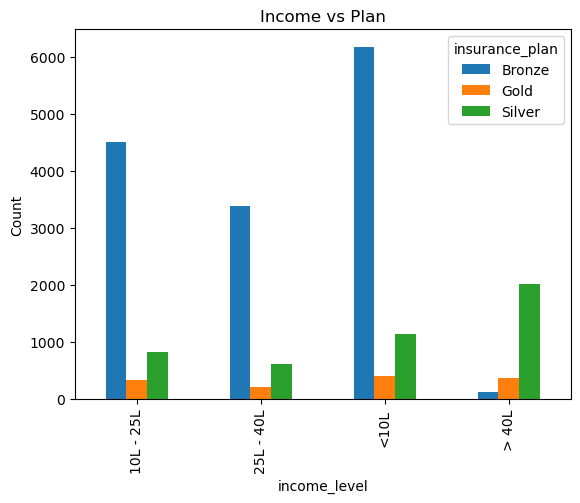

In [34]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
crosstab
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

The chart shows how insurance plan choices vary by income level. Bronze plans dominate in lower income groups, while Silver plans become more common as income increases. Gold plans remain the least selected across all income levels.

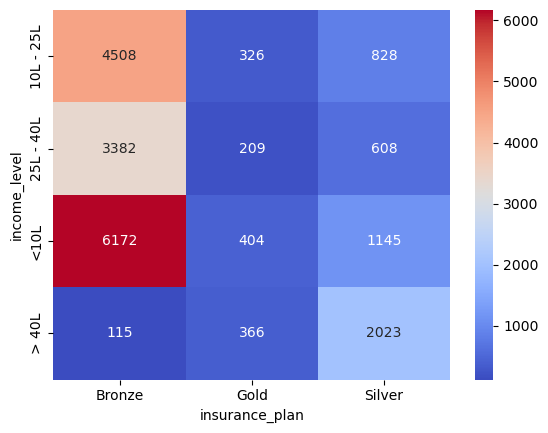

In [35]:
sns.heatmap(crosstab, annot=True, fmt='d', cmap='coolwarm')
plt.show()

This heatmap shows how many people from each income group chose each insurance plan. Lower-income groups overwhelmingly picked the Bronze plan, while higher-income groups were more likely to choose Silver or Gold. The color intensity reflects the magnitude of enrollments in each category.

In [36]:
# checking the data
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [37]:
# #  Getting the different categories of medical history
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
# Adding the risk score  for differenct medical category
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Split medical_history into two columns
df2[['disease1', 'disease2']] = (
    df2['medical_history']
    .str.lower()               # convert entire string to lowercase
    .str.split("&", expand=True)
)

# Replace missing diseases with 'none'
df2['disease1'] = df2['disease1'].fillna('none').str.strip()
df2['disease2'] = df2['disease2'].fillna('none').str.strip()

df2.head()


,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,none


In [39]:
# Fill missing disease values
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

# Initialize total score
df2['total_risk_score'] = 0

# Add scores for each disease
for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += (
        df2[disease].map(risk_scores).fillna(0)
    )

# Normalize the risk score
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

if max_score != min_score:
    df2['normalized_risk_score'] = (
        (df2['total_risk_score'] - min_score) /
        (max_score - min_score)
    )
else:
    df2['normalized_risk_score'] = 0   # All scores identical → normalized = 0

df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,none,0,0.000000


In [40]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [41]:
# Mapping the Insurance Plan
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [42]:
# Mapping the Income Level
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [43]:
# Getting dummies for nominal value columns
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first =True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,2,no disease,none,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,1,no disease,none,...,1,0,1,0,1,0,0,0,0,0


In [44]:
# Dropping the columns
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


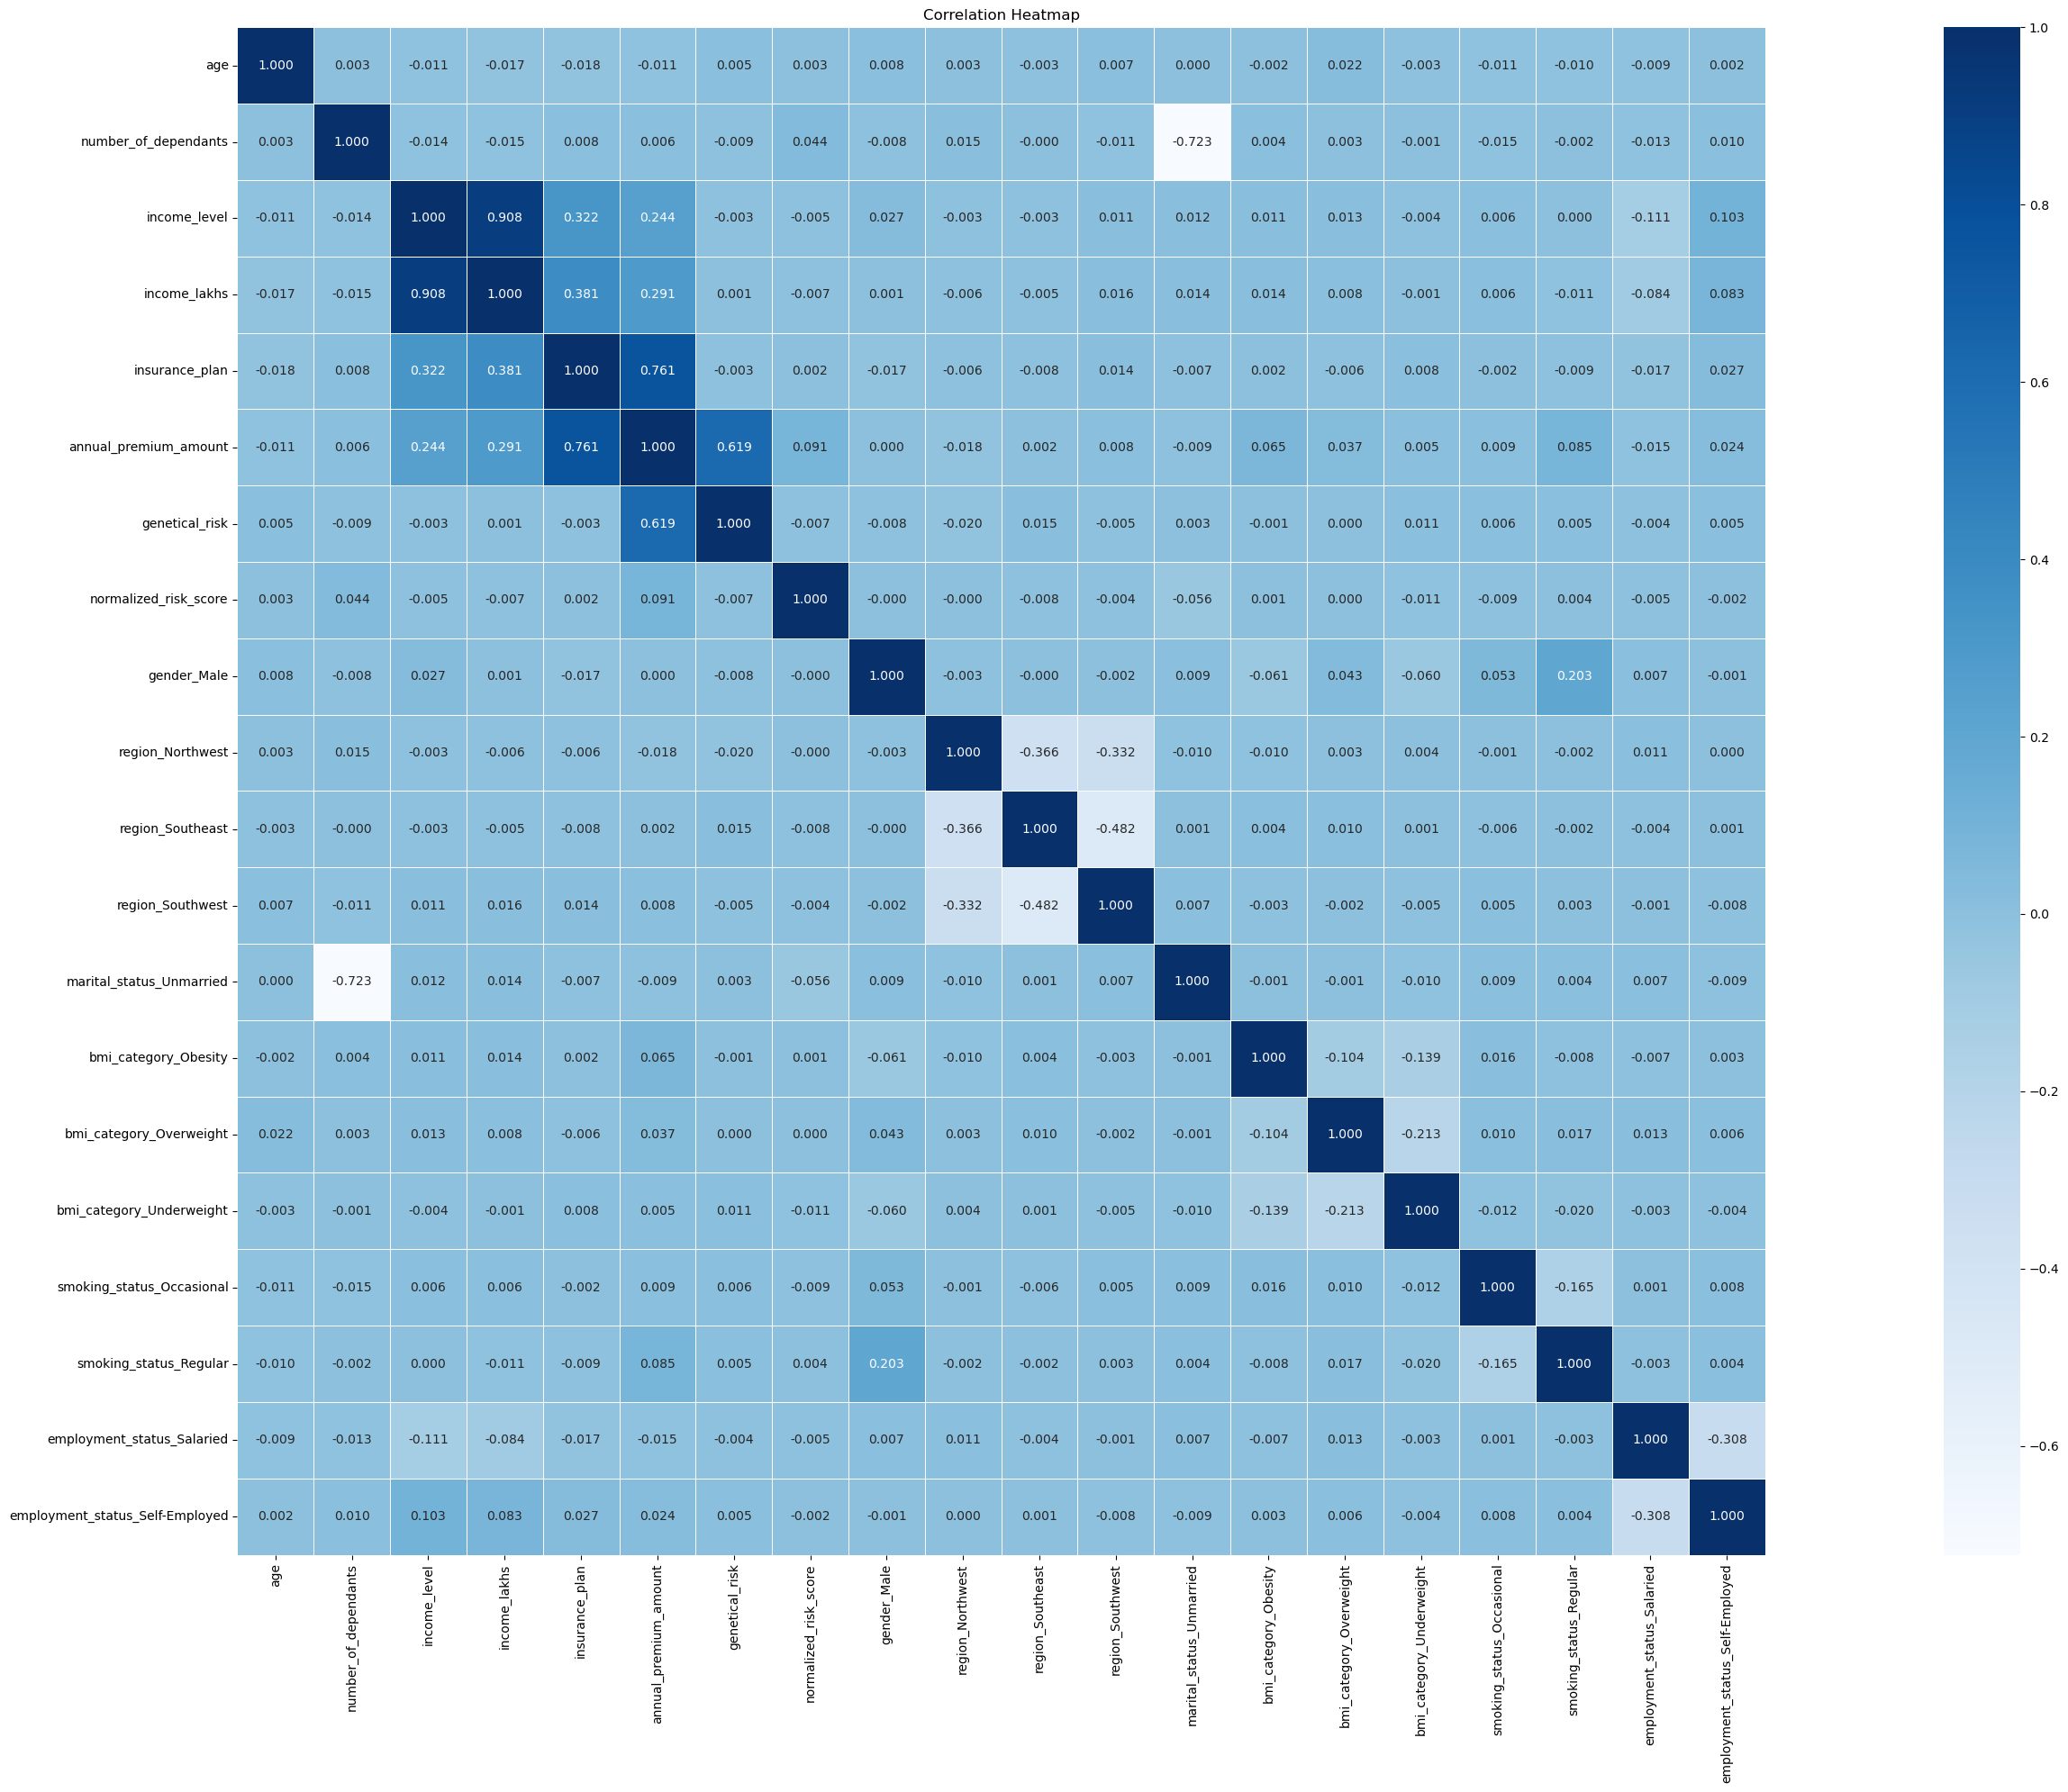

In [45]:
# Select only numeric columns for correlation
corr_matrix = df4.corr()

# Set up the matplotlib figure
plt.figure(figsize=(40, 20))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".3f", linewidths=0.5, square=True)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Heatmap shows mostly weak correlations, meaning features are fairly independent.

Strongest relationships involve income, income stability, and annual premium.

Medical risk also strongly influences premiums.

Categorical demographic variables (gender, region, BMI category, smoking status, employment status) have minimal linear relationships with others.

In [46]:
# Scalling the necessary columns 
X = df4.drop('annual_premium_amount', axis='columns')
y= df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants','income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [47]:
# Getting the information
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# Calculate the Vif score
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


The VIF table checks multicollinearity among your model’s features. Most variables have acceptable VIF values (below 5), indicating low to moderate correlation. However, income_level and income_lakhs have very high VIF (>10), showing severe multicollinearity.

In [50]:
# Dropping the income_level
calculate_vif(X.drop('income_level', axis ='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


On dropping the income level, the VIF values are within acceptable limit.

In [51]:
# # dropping the income level
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## Model Training

In [52]:
# importing the necessary training library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', X_train.shape)
print('y_test:', y_test.shape)

X_train: (14060, 18)
X_test: (6026, 18)
y_train: (14060, 18)
y_test: (6026,)


## Using Linear Regression

In [53]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.988297900194864, 0.9887263253056615)

In [54]:
# Making the prediction
y_preds = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_preds)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE:", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE: 85732.34377930455 RMSE:  292.80086027760325


In [55]:
# model coefficients
model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

In [56]:
X_test.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalized_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [57]:
# creating a dataframe for coefficient
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df

,Coefficients
age,-7.229032
number_of_dependants,19.536182
income_lakhs,-1.264528
insurance_plan,7001.125261
genetical_risk,4996.988728
normalized_risk_score,1109.148365
gender_Male,8.177988
region_Northwest,1.677353
region_Southeast,-3.275327
region_Southwest,6.317095


In [58]:
# sorting the feature importance
coef_df = coef_df.sort_values(by = 'Coefficients', ascending=True)
coef_df

,Coefficients
age,-7.229032
employment_status_Self-Employed,-5.242018
region_Southeast,-3.275327
income_lakhs,-1.264528
employment_status_Salaried,0.038784
region_Northwest,1.677353
region_Southwest,6.317095
gender_Male,8.177988
marital_status_Unmarried,16.068972
number_of_dependants,19.536182


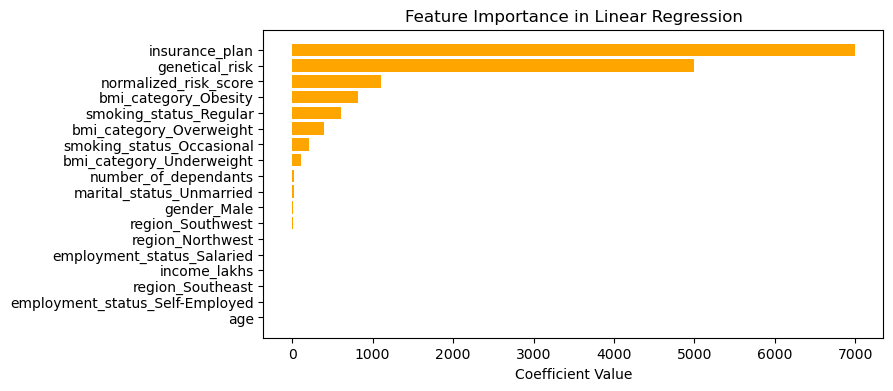

In [59]:
# Plotting the feature importance
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='orange')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

The chart shows feature importance based on linear regression coefficients, where larger bars mean a stronger impact on the prediction.
Insurance plan and genetical risk are the most influential factors by a large margin.
Health-related variables like BMI category, smoking status, and risk score have moderate influence.
Demographics such as age, gender, region, and employment contribute very little to the model.


### Using Ridge Regression

In [60]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9882972960153418, 0.9887275909694276)

### Using XGBoost Regression

In [61]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9925054907798767, 0.987729549407959)

In [62]:
# making prediction
y_preds = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_preds)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE: 93312.69206188193 RMSE:  305.4712622520847


In [63]:
best_model = model_lr

### Error Analysis

In [64]:
y_preds = best_model.predict(X_test)

residuals = y_preds - y_test
residuals_pct = residuals*100/ y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_preds,
    'diff' : residuals,
    'diff_pct': residuals_pct

})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


<Axes: xlabel='diff_pct', ylabel='Count'>

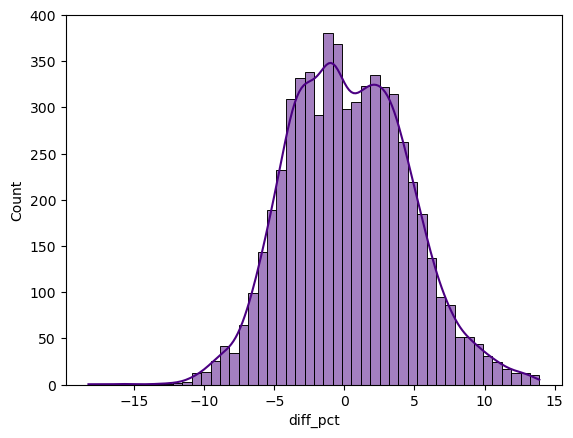

In [65]:
# plotting the percentage difference
sns.histplot(results_df['diff_pct'], kde=True, color='indigo')

In [66]:
# Getting rows where percentage difference is greater than extreme error
extreme_error_threshold = 10

extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(129, 4)

In [67]:
# percentage of rows where percentage difference is greater than extreme error
extreme_errors_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

2.140723531364089

In [68]:
results_df[np.abs(results_df.diff_pct)>50]

,actual,predicted,diff,diff_pct


In [69]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [70]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [71]:
extreme_results_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [72]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


## Conclusion Summary

This analysis developed a robust predictive model for estimating annual health insurance premiums for young adults (18–25), integrating demographic, lifestyle, medical, income, and genetic risk factors. Through rigorous data cleaning, exploratory analysis, feature engineering, and multicollinearity assessment, insurance plan and genetic risk emerged as the dominant drivers of premium variation, while most demographic variables showed limited linear impact.

Linear Regression delivered the best performance, achieving an R² of ~0.99 on both training and test sets with low error (RMSE ≈ 293), and only ~2% of predictions showing errors above 10%. Ridge Regression and XGBoost produced comparable results, confirming the stability of the modeling approach.

Despite some synthetic characteristics in the data, the model provides meaningful insights for premium personalization and risk-based pricing. Future improvements may include richer lifestyle features, validation on real-world datasets, and deployment as an interactive application to support data-driven insurance decision-making.

## Export the model

In [73]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [74]:
from joblib import dump

In [75]:
dump(best_model, "artifacts/model_young.joblib")

['artifacts/model_young.joblib']

In [76]:
scaler_with_cols = {
    'scaler' : scaler,
    'cols_to_scale' : cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']